In [1]:
import matplotlib.pyplot
import numpy.random
import torch.utils.data
import torchvision
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Module
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

# Tutorial 1a. Logistic Regression

In the first tutorial, we are going to train a logistic regressor on the MNIST dataset of handwritten digits. Next, we will turn this logistic regressor into a non-linear convolutional network.

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

## Loading Datasets

The following code will load the MNIST dataset. Run it and inspect some of the images and their labels to confirm they are correct.

In [3]:
train_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=True,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=MNIST(
        root="/tmp/mnist",
        train=False,
        transform=ToTensor(),
        download=True,
    ),
    batch_size=64,
    shuffle=False,
)

(-0.5, 27.5, 27.5, -0.5)

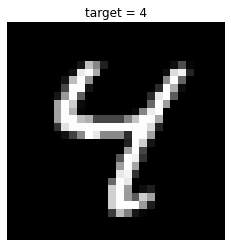

In [4]:

image, target = [*test_dataloader][0]

random_index = numpy.random.randint(0, 64)

image, target = image[random_index, 0], target[random_index]

matplotlib.pyplot.imshow(
    image, 
    cmap="gray", 
    interpolation="nearest",
)

matplotlib.pyplot.title(f"target = {target}")
matplotlib.pyplot.axis("off")

Next, we create a PyTorch dataloader for the MNIST dataset.

Next, implement a logistic regression model in PyTorch. Note that a logistic regressor uses a linear transformation of the input.


## Exercise 1. Logistic Regression Module

In [5]:
class LogisticRegression(Module):
    def __init__(self, input_size: int, num_classes: int):
        super().__init__()

        ###########################################################################
        # TODO: Instantiate the layer here.  
        self.linear = nn.Linear(input_size, num_classes)                                     #
        ###########################################################################

    def forward(self, x: Tensor) -> Tensor:
        ###########################################################################
        # TODO: Apply the layer to the input.   
        x =  x.view(-1, 28*28) 
        out = self.linear(x)                                #
        ###########################################################################
        return out

In [6]:
model = LogisticRegression(28 * 28, 10)

model = model.to(device=DEVICE)

In [7]:
###########################################################################
# TODO: Create criterion and optimizer here.                              #
###########################################################################

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) 

## Training

We will use the following generic training loop for a PyTorch model.

In [9]:
# Train the model. If everything is correct, the loss should go below 0.45.

EPOCHS = 5

# Exponential moving average of the loss:
ema = None
model.train()
for epoch in range(EPOCHS):
    for batch_index, (train_images, train_targets) in enumerate(train_dataloader):
        train_images = train_images.view(-1, 28 * 28).requires_grad_().to(device=DEVICE)

        train_targets = train_targets.to(device=DEVICE)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(train_images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_targets)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updates parameters:
        optimizer.step()

        # NOTE: It is important to call .item() on the loss before summing.
        if ema is None:
            ema = loss.item()
        else:
            ema += (loss.item() - ema) * 0.01

        if batch_index % 500 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_index * len(train_images),
                    len(train_dataloader.dataset),
                    100.0 * batch_index / len(train_dataloader),
                    ema,
                ),
            )

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.341558
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.351374
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.324024
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.320722
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.308646
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.290243
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.313460
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.296212
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.305013
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.291699


**Question:** For the model you are currently using, is there any difference between using the model in `train` mode or using it in `eval` mode? 

# `Ans`: Yes. There is a difference with using the model in train and eval model.For train model,the model is initialize in train model and all necessary/required layers are activated (Example, if Batchnorm is True or False, it will use per-layer statistics or Dropout layer will be activated if used), whereas for eval model, the model is set in evaluation mode(Dropout deactivated and Batch norm uses running statistics). See implementation for eval() mode below.

Create an SGD optimizer and use it to train the logistic regressor on the MNIST training data for a few epochs. What loss function do you need to use?

Loss function = Cross Entropy Loss for multiclass classification

In [10]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01) 

# Train the model. If everything is correct, the loss should go below 0.45.

EPOCHS = 5

# Exponential moving average of the loss:
ema = None
model.train()

for epoch in range(EPOCHS):
    for batch_index, (train_images, train_targets) in enumerate(train_dataloader):
        train_images = train_images.view(-1, 28 * 28).requires_grad_().to(device=DEVICE)

        train_targets = train_targets.to(device=DEVICE)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(train_images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_targets)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updates parameters:
        optimizer.step()

        # NOTE: It is important to call .item() on the loss before summing.
        if ema is None:
            ema = loss.item()
        else:
            ema += (loss.item() - ema) * 0.01

        if batch_index % 500 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_index * len(train_images),
                    len(train_dataloader.dataset),
                    100.0 * batch_index / len(train_dataloader),
                    ema,
                ),
            )

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.235309
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.248012
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.240310
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.231798
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.254303
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.243207
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.233999
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.234505
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.224682
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.229853


### Embeddings 

Visualize the weights of the trained model. What do you see? Why?

In [12]:
assert model.linear.weight.shape == (10, 28 * 28)

In [18]:

import PIL
import imageio
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
%matplotlib inline

def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.grid(False)
    plt.gca().axis('off')

def display_thumb(img):
  display.display(transforms.Resize(128)(img))

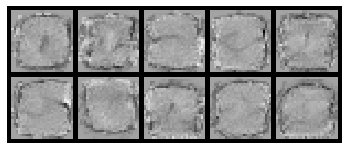

In [19]:
show(torchvision.utils.make_grid(
    model.linear.weight.view(10, 1, 28, 28),
    normalize=True,
    nrow=5,
))

## Evaluation

Use the following function to measure the test accuracy of your trained model.

In [21]:
correct_predictions = 0
predictions = 0
model.eval()
# Iterate through test dataset
with torch.no_grad():
  for test_images, test_targets in test_dataloader:
      test_images = test_images.view(-1, 28 * 28).to(DEVICE)

      # Forward pass only to get logits/output
      outputs = model(test_images)

      # Get predictions from the maximum value
      _, predicted = torch.max(outputs.data, 1)

      predictions += test_targets.size(0)

      if torch.cuda.is_available():
          correct_predictions += (predicted.cpu() == test_targets.cpu()).sum()
      else:
          correct_predictions += (predicted == test_targets).sum()

  print(correct_predictions.item() / predictions)

0.9274


In [22]:
!git init

Initialized empty Git repository in /content/.git/


In [23]:
!git clone https://github.com/Aminah92/Computer-Vision-Projects.git

Cloning into 'Computer-Vision-Projects'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 20 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), 631.58 KiB | 7.43 MiB/s, done.


In [24]:
!ls

Computer-Vision-Projects  sample_data


In [25]:
!pwd

/content


In [ ]:
!mv "/content/Computer-Vision-Projects/Covnet Tutorials from AMMI/Image Classification and Identification"

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
